In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#import data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55.18M,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40.78M,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38.86M,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34.45M,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37.30M,1.50%


In [7]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [8]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55180000.0,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40780000.0,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38860000.0,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34450000.0,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37300000.0,1.50%
...,...,...,...,...,...,...,...
1619,6/9/2023,124.92,123.57,127.25,123.55,75110000.0,3.20%
1620,6/12/2023,129.19,128.52,130.48,126.40,85220000.0,3.42%
1621,6/13/2023,124.53,132.32,132.83,122.45,131670000.0,-3.61%
1622,6/14/2023,127.33,126.53,127.72,123.81,95240000.0,2.25%


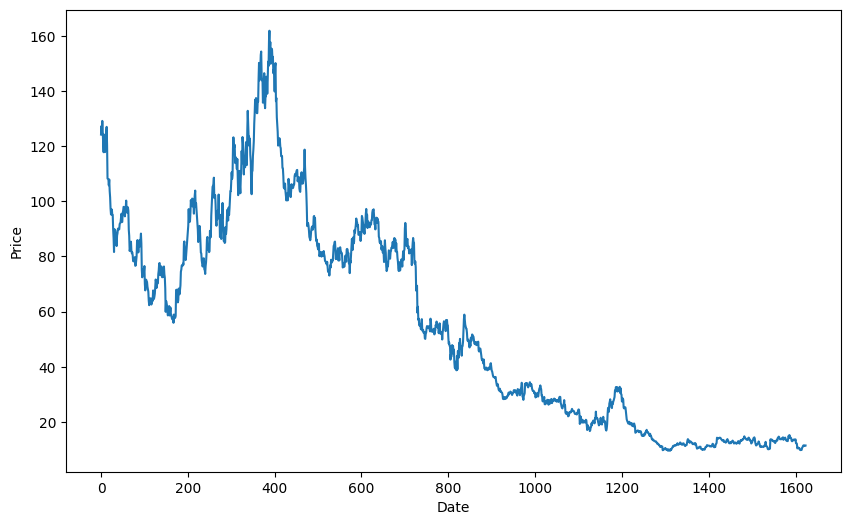

In [9]:
#Đảo ngược dữ liệu cho mô hình
df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [10]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [11]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [12]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [13]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...


Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [14]:
# Predict on validation set
my_dlm.predictN(N=30)


([25.011425108417065,
  24.597373381062052,
  24.891395951484306,
  24.257531815263643,
  24.725699709496105,
  24.85073556557704,
  24.011644048799347,
  24.907466588306953,
  24.359906207193518,
  24.517218787510068,
  23.83136780819332,
  23.69678888023275,
  23.194172034862333,
  22.429712823898903,
  23.44771249498802,
  22.606354212434535,
  23.071911073470805,
  23.735747139184657,
  24.225033805384456,
  24.16331907088731,
  23.578763887973768,
  23.82306818010248,
  23.7067969643437,
  23.57326680548152,
  23.738525804123224,
  23.31135425116061,
  23.042605760637066,
  23.336260664050375,
  23.314730438804236,
  23.642343582297222],
 [252.00720395649495,
  251.0105872720149,
  250.0232218414294,
  249.0450152825179,
  248.07587594089324,
  247.11571289305823,
  246.16443594915756,
  245.22195565544325,
  244.28818329645966,
  243.36303089696372,
  242.44641122357882,
  241.53823778620216,
  240.63842483916793,
  239.74688738217023,
  238.8610498334212,
  237.98575709685102,
 

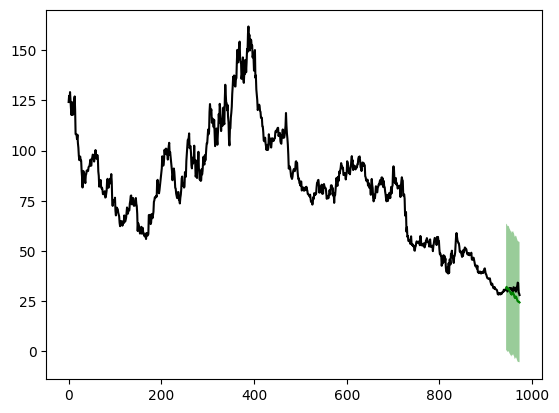

In [15]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [16]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [17]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [18]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 33.77474791736292
Testing MSE: 1140.733596881411
Testing MAE: 29.89120999586326
Validation RMSE: 7.182689379180336
Validation MSE: 51.59102671779
Validation MAE: 6.46573128593782


In [20]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [21]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[25.011425108417065, 24.597373381062052, 24.891395951484306, 24.257531815263643, 24.725699709496105, 24.85073556557704, 24.011644048799347, 24.907466588306953, 24.359906207193518, 24.517218787510068, 23.83136780819332, 23.69678888023275, 23.194172034862333, 22.429712823898903, 23.44771249498802, 22.606354212434535, 23.071911073470805, 23.735747139184657, 24.225033805384456, 24.16331907088731, 23.578763887973768, 23.82306818010248, 23.7067969643437, 23.57326680548152, 23.738525804123224, 23.31135425116061, 23.042605760637066, 23.336260664050375, 23.314730438804236, 23.642343582297222]


In [22]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [23]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


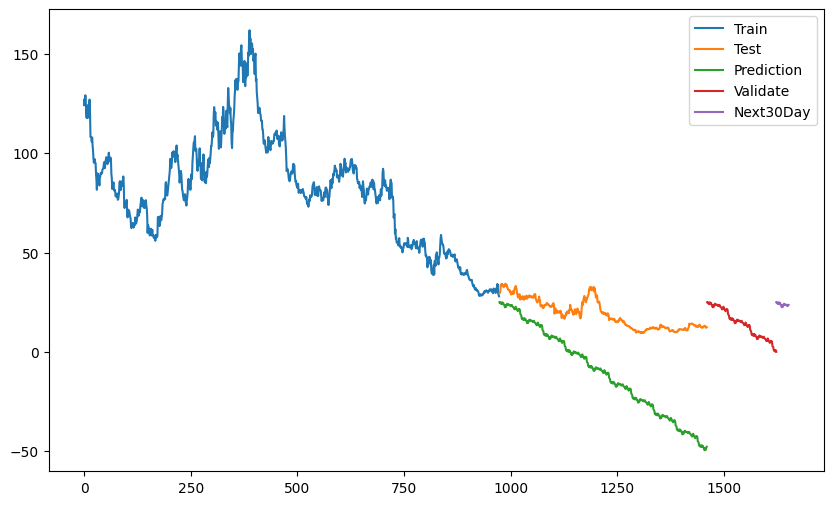

In [24]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
#plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'])
plt.show()